# Integração Numérica

#### baseado nas seções 6.2, 6.3 e 6.4 do livro "Linge, Svein, and Langtangen, Hans Petter. Programming for Computations - Python: A Gentle Introduction to Numerical Simulations with Python 3.6"

> "A desvantagem (aparente) de um método numérico é que ele só consegue encontrar uma resposta aproximada. Deixar o exato pelo aproximado é uma barreira mental no início, mas lembre-se que a maioria das aplicações reais de integração envolverá uma função $f(x)$ que contém parâmetros físicos, que são medidos com algum erro. Ou seja, $f(x)$ raramente é exato, e não faz sentido tentar calcular a integral com um erro menor que o já presente em $f(x)$"

> "Outra vantagem dos métodos numéricos é que podemos integrar facilmente uma função $f(x)$ que só é conhecida como amostras, ou seja, valores discretos em alguns pontos $x$, e não como uma função contínua de $x$ expressa através de uma fórmula. Isto é altamente relevante quando $f$ é medido em um experimento físico" (*Programming for Computations - Python: A Gentle Introduction to Numerical Simulations with Python 3.6*)

## Ideia básica da Integração Numérica 

\begin{equation}
\int_a^b f(x)~dx \label{eq:int}
\end{equation}
particionar o intervalo original $[a,b]$ em subintervalos menores, selecionando para isso **pontos de integração** $x_i$, $i = 0,1,\ldots,n$ (com $x_0 = a$ e $x_n = b)$. Para o caso igualmente espaçado temos $$x_i = a + ih, \quad i = 0,1,\ldots,n,$$ com $$h = \dfrac{b-a}{n}.$$

A integral então pode ser expressa como
\begin{equation}
\int_a^b f(x)~dx = \int_{x_0}^{x_1} f(x)~dx + \int_{x_1}^{x_2} f(x)~dx + \cdots + \int_{x_{n-1}}^{x_n} f(x)~dx,
\end{equation}
e como veremos os métodos de integração diferem na forma como eles aproximam os termos do lado direito, sendo a ideia principal de que sendo $[x_i, x_{i+1}]$ suficientemente pequeno faz sentido aproximar $f$ nesse subintervalo por funções mais simples como constante, afim, quadrática, etc que podem ser facilmente integradas. 

### Exemplo analítico para validação

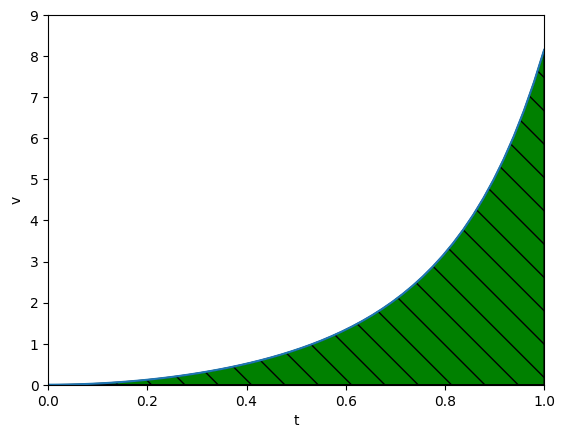

In [7]:
import numpy as np
import matplotlib.pyplot as plt

a = 0.0
b = 1.0

nplot = 50
 
t = np.linspace(a,b,nplot)
v = 3.0*(t**2)*np.exp(t**3)

plt.plot(t,v)
plt.xlim(0.0,1.0)
plt.xlabel('t')
plt.ylim(0.0,9.0)
plt.ylabel('v')
plt.fill_between(t,v, facecolor="g", hatch="\\", edgecolor="k")
plt.show()

Nesse caso a integral $\int_0^1 v(t)~dt$ com $v(t) = 3t^2e^{t^3}$ pode ser feita pela regra da substituição, dando $e-1$. Vamos usá-la para medir a precisão dos métodos.

## Regra Trapezoidal Composta

Regra para aproximação por trapézios de mesma "altura":

\begin{align}
\int_a^b f(x)~dx &= \int_{x_0}^{x_1} f(x)~dx + \int_{x_1}^{x_2} f(x)~dx + \cdots + \int_{x_{n-1}}^{x_n} f(x)~dx, \\
&\approx h \dfrac{f(x_0) + f(x_1)}{2} + h \dfrac{f(x_1) + f(x_2)}{2} + \cdots + h \dfrac{f(x_{n-1}) + f(x_n)}{2}, \\
&\approx \dfrac{h}{2} [f(x_0) + 2f(x_1) + 2f(x_2) + \ldots + 2f(x_{n-1}) + f(x_n)].
\end{align}

Ou na forma compacta
\begin{equation}
\int_a^b f(x)~dx \approx h \left[ \dfrac{1}{2} f(x_0) + \sum_{i=1}^{n-1} f(x_i) + \dfrac{1}{2} f(x_n) \right].
\end{equation}

Portanto o que precisamos abstrair para ter um implementação geral do método? Pensando em termos de função, quais os argumentos que passaríamos para uma função em Python? 

In [8]:
def trapezoidal(f, a, b, n): 
    h = (b-a)/n 
    f_sum = 0.0 
    for i in range(1, n, 1): 
        x = a + i*h 
        f_sum = f_sum + f(x) 
    return h*(0.5*f(a) + f_sum + 0.5*f(b))

In [9]:
def trapezoidal2(f, a, b, n): 
    h = (b-a)/n 
    result = 0.5*f(a) + 0.5*f(b) 
    for i in range(1, n): 
        result += f(a + i*h) 
    return result*h

In [10]:
from math import exp

# Atente para a definição de uma função lambda. Facilita a vida, principalmente quando queremos passar uma função como 
# argumento de uma função

v = lambda t: 3*(t**2)*exp(t**3)

n = 4
numerical = trapezoidal(v, 0., 1., n)

# Compare with exact result
V = lambda t: exp(t**3)
exact = V(1.) - V(0.)
error = abs(exact - numerical)
print('n={:d}: {:.16f}, error: {:g}'.format(n, numerical, error))
print('relative error = {:g}%'.format((error/exact)*100))

n=4: 1.9227167504675762, error: 0.204435
relative error = 11.8976%


In [11]:
n = 400
numerical = trapezoidal(v, 0., 1., n)
error = abs(exact - numerical)
print('n={:d}: {:.16f}, error: {:g}'.format(n, numerical, error))
print('relative error = {:g}%'.format((error/exact)*100))

n=400: 1.7183030649495579, error: 2.12365e-05
relative error = 0.00123591%


#### Observação
> O Jupyter Notebook é equivalente a uma sessão interativa, se quisermos usar nossa implementação em um programa, melhor é colocar as funções em um arquivo, neste caso `trapezoidal.py` 

## Regra do Ponto Médio Composta

Ao invés de aproximar cada sub-área por um trapézio, podemos aproximar por um retângulo tomando como altura o valor da função avaliada no **ponto médio** do sub-intervalo. Ficamos portanto com fórmula (para intervalos igualmente espaçados):

\begin{align}
\int_a^b f(x)~dx &= \int_{x_0}^{x_1} f(x)~dx + \int_{x_1}^{x_2} f(x)~dx + \cdots + \int_{x_{n-1}}^{x_n} f(x)~dx, \\
&\approx h f \left( \dfrac{x_0 + x_1}{2} \right) +  h f \left( \dfrac{x_1 + x_2}{2} \right) + \cdots +  h f \left( \dfrac{x_{n-1} + x_n}{2} \right), \\
&\approx h \left( f \left( \dfrac{x_0 + x_1}{2} \right) +  f \left( \dfrac{x_1 + x_2}{2} \right) + \cdots +  f \left( \dfrac{x_{n-1} + x_n}{2} \right)  \right).
\end{align}

Ou na forma compacta
\begin{equation}
\int_a^b f(x)~dx \approx h \sum_{i=0}^{n-1} f(x_i),
\end{equation}
com $x_i = \left( a + \frac{h}{2} \right) + ih$ para $i = 0, \ldots, n-1$.

<div class="alert alert-block alert-danger">
    A implementação será colocada num arquivo <i>midpoint.py</i> para ser importada como um módulo.
</div>

In [12]:
from midpoint import midpoint
n = 4
numerical = midpoint(v, 0., 1., n)
error = abs(exact - numerical)
print('n={:d}: {:.16f}, error: {:g}'.format(n, numerical, error))
print('relative error = {:g}%'.format((error/exact)*100))

ModuleNotFoundError: No module named 'midpoint'

<div class="alert alert-block alert-info">
Observe que o erro relativo foi melhor na regra do ponto médio, apesar de geomatricamente parecer ser contra intuitivo (trapézios parecem aproximar melhor que retângulos) veremos o porque adiante. Na prática isso acaba não sendo tão significativo pois podemos usar um $n$ bem grande como $n = 10^5$ e obter um erro bem pequeno (da ordem de $10^{-10}$) bem rápido.
</div>

In [ ]:
n = 10**5
numerical = trapezoidal(v, 0., 1., n)
error = abs(exact - numerical)
print('n={:d}: {:.16f}, error: {:g}'.format(n, numerical, error))
print('relative error = {:g}%'.format((error/exact)*100))

## Vetorizando as funções (ganhando desempenho)

> A lição é clara, mesmo que uma função leve frações de segundos para executar, sempre tente vetorizar os *loops*. (*Adriano Côrtes, 2023*)

#### Vetorizando a regra do ponto médio

In [ ]:
from numpy import linspace, sum, exp   

# É fundamental você exportar a função exp acima, caso contrário a lambda function definida anteriormente 
# dará erro pois a função exp do módulo math não aceita arrays como argumento como já vimos

def midpoint_vec(f, a, b, n):
    h = (b-a)/n
    x = linspace(a + h/2, b - h/2, n)
    return h*sum(f(x))

In [ ]:
n = 100
numerical = midpoint(v, 0., 1., n)
error = abs(exact - numerical)
print('n={:d}: {:.16f}, error: {:g}'.format(n, numerical, error))
print('relative error = {:g}%'.format((error/exact)*100))

print('-----------------')
print('Versão Vetorizada')

numerical = midpoint_vec(v, 0., 1., n)
error = abs(exact - numerical)
print('n={:d}: {:.16f}, error: {:g}'.format(n, numerical, error))
print('relative error = {:g}%'.format((error/exact)*100))

n=100: 1.7181119551669362, error: 0.000169873
relative error = 0.00988623%
-----------------
Versão Vetorizada
n=100: 1.7181119551669362, error: 0.000169873
relative error = 0.00988623%


#### Vetorizando a regra trapezoidal

In [ ]:
def trapezoidal_vec(f, a, b, n):
    h = (b-a)/n
    x = linspace(a, b, n+1)
    s = sum(f(x)) - 0.5*f(a) - 0.5*f(b)
    return h*s

In [ ]:
n = 100
numerical = trapezoidal(v, 0., 1., n)
error = abs(exact - numerical)
print('n={:d}: {:.16f}, error: {:g}'.format(n, numerical, error))
print('relative error = {:g}%'.format((error/exact)*100))

print('-----------------')
print('Versão Vetorizada')

numerical = trapezoidal_vec(v, 0., 1., n)
error = abs(exact - numerical)
print('n={:d}: {:.16f}, error: {:g}'.format(n, numerical, error))
print('relative error = {:g}%'.format((error/exact)*100))

n=100: 1.7186215916047789, error: 0.000339763
relative error = 0.0197734%
-----------------
Versão Vetorizada
n=100: 1.7186215916047791, error: 0.000339763
relative error = 0.0197734%


### Medindo o *speed up* ganho com a vetorização

In [ ]:
import timeit

In [ ]:
n = 10**6

In [ ]:
time_midpoint = %timeit -o midpoint(v, 0., 1., n)

In [ ]:
print('Tempo: {:g} segundos'.format(time_midpoint.average))

In [ ]:
time_midpoint_vec = %timeit -o midpoint_vec(v, 0., 1., n)

In [ ]:
print('Tempo: {:g} segundos'.format(time_midpoint_vec.average))

In [ ]:
print('Fator de Eficiência: {:g}'.format(time_midpoint.average/time_midpoint_vec.average)) 

## Taxa de Convergência 

Já vimos nos exemplos anteriores nas células acima que ao aumentarmos o número de subintervalos o erro decresce, o que é plausível e esperado, porém a pergunta que podemos fazer é qual a velocidade dessa redução, ou seja, quão rápido o erro está decrescendo (assintoticamente falando).

Como o parâmetro que podemos ajustar é $h$, procuramos um erro que seja função de $h$, como 

$$E(h) = Kh^r,$$

onde $K$ é uma constante positiva e $r$ é a **taxa de convergência** (que obviamente dependerá do método em questão). Portanto, quanto maior $r$ mais rápido temos $E \to 0$ quando $h \to 0$. Dizemos nesse caso que o método é de **ordem $r$**.

No caso específico da integração numérica, apesar de $h$ ser o que entra na fórmula matemática, no programa usamos o parâmetro $n$ (o número de subintervalos), portanto nesse caso é mais cômodo reparametrizar o erro para ser em função $n$. Com efeito, substituindo $h = (b-a)/n$ na expressão acima teremos, 

\begin{align}
E &= Kh^r, \\
  &= K \left(\dfrac{b-a}{n} \right)^r, \\
  &= K (b-a)^r \left(\dfrac{1}{n} \right)^r, \\
  &= C n^{-r},
\end{align}

onde $C = K (b-a)^r$, dando $$E(n) = Cn^{-r}.$$

Para encontrar $r$ tendo-se um conjunto de dados, vamos passar o $\log$ na expressão para termos 

$$\log E(n) = \log(Cn^{-r}) = -r\log(n) + \log(C),$$

Assim teremos uma relação linear na escala $\log$.

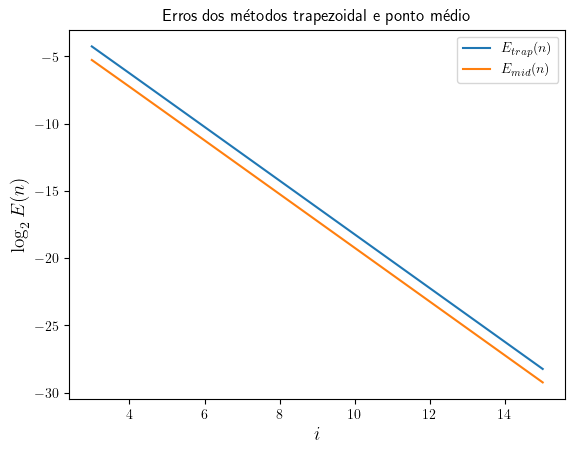

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

nerrors = range(3,16)
errors_mid = []
errors_trap = []

for i in nerrors:
    n = 2**i
    
    numerical_trap = trapezoidal_vec(v, 0., 1., n)
    numerical_mid = midpoint_vec(v, 0., 1., n)
    
    error_trap = abs(exact - numerical_trap)
    error_mid = abs(exact - numerical_mid)
    
    errors_trap.append(error_trap)
    errors_mid.append(error_mid)
    
    
errors_trap_log2 = np.log2(np.array(errors_trap))
errors_mid_log2 = np.log2(np.array(errors_mid))


plt.rc('text', usetex=True)
plt.plot(np.array(nerrors), errors_trap_log2, label=r'$E_{trap}(n)$')
plt.plot(np.array(nerrors), errors_mid_log2, label=r'$E_{mid}(n)$')
plt.legend()
plt.title('Erros dos métodos trapezoidal e ponto médio')
plt.xlabel(r'$i$', fontsize=14)
plt.ylabel(r'$\log_2 E(n)$', fontsize=14)
plt.show()

In [ ]:
est_r_trap = np.diff(errors_trap_log2)
print(est_r_trap)

[-1.98924594 -1.99726774 -1.99931412 -1.99982835 -1.99995708 -1.99998927
 -1.99999732 -1.99999933 -1.99999983 -1.99999996 -1.99999998 -1.99999995]


In [ ]:
est_r_mid = np.diff(errors_mid_log2)
print(est_r_mid)

[-1.98114857 -1.9952165  -1.99879958 -1.99969961 -1.99992488 -1.99998122
 -1.99999531 -1.99999883 -1.99999971 -1.99999994 -2.         -2.0000001 ]


### Conclusão

Podemos numericamente afirmar que ambos métodos de integração numérica são métodos de ordem 2, ou seja, $r=2$.

## Teorema (Fórmula) de Taylor

Material e explicação em sala de aula

## Teoria do erro para os métodos acima

Material e explicação em sala de aula